In [66]:
import itertools
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import numpy as np
import tqdm

from db_queries import get_location_metadata

In [67]:
parameters = {
    'variant': ('worse', 'reference'),
    'mask': ('return', 'flat', 'best'),
    'vaccine': ('reference', 'best'),
    'mobility': ('average', 'return'),
    'cvi': ('low', 'moderate', 'high'),
    'scale': ('low', 'high')
}

In [43]:
data = []
for variant, mask, vaccine, mobility, cvi, scale in tqdm.tqdm(list(itertools.product(*parameters.values()))):
    scenario = f'variant_{variant}_mask_{mask}_vaccine_{vaccine}_mobility_{mobility}_cvi_{cvi}_scale_{scale}'
    df = pd.read_csv(f'/ihme/covid-19-2/seir-outputs/2021_03_08.02/{scenario}/output_summaries/daily_deaths.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df[(pd.Timestamp('2021-08-01')<=df.date) & (df.date<=pd.Timestamp('2022-08-01'))]
    df = df.groupby('location_id')['mean'].sum().rename('deaths').reset_index()
    
    
    df['variant'] = variant
    df['mask'] = mask
    df['vaccine'] = vaccine
    df['mobility'] = mobility
    df['cvi'] = cvi
    df['scale'] = scale
    df = df.set_index(['location_id', 'variant', 'mask', 'vaccine', 'mobility', 'cvi', 'scale']).sort_index()
    data.append(df)

100%|██████████| 144/144 [00:41<00:00,  3.44it/s]


In [45]:
df = pd.concat(data).sort_index()

In [82]:
df.loc[4752].reset_index()

,variant,mask,vaccine,mobility,cvi,scale,deaths,location_ascii_name
0,reference,best,best,average,high,high,1.240473e+06,Amazonas
1,reference,best,best,average,high,low,7.118520e+15,Amazonas
2,reference,best,best,average,low,high,3.125008e-02,Amazonas
3,reference,best,best,average,low,low,1.038544e-02,Amazonas
4,reference,best,best,average,moderate,high,6.142626e-03,Amazonas
...,...,...,...,...,...,...,...,...
139,worse,return,reference,return,high,low,3.326218e+14,Amazonas
140,worse,return,reference,return,low,high,1.562372e+01,Amazonas
141,worse,return,reference,return,low,low,4.139116e+00,Amazonas
142,worse,return,reference,return,moderate,high,2.207371e+00,Amazonas


In [65]:
md = df.groupby('location_id').max().deaths
md[md > 1e10]

location_id
1        1.114875e+20
103      1.114875e+20
134      1.114875e+20
135      1.114875e+20
479      1.114875e+20
4752     1.114875e+20
44564    1.114875e+20
Name: deaths, dtype: float64

In [80]:
h = get_location_metadata(111, location_set_version_id=771)
name_map = h.set_index('location_id').location_ascii_name
#df = df.join(name_map, on='location_id')
name_map.loc[4752]

'Amazonas'

In [105]:
most_detailed = h[(h.most_detailed == 1) & (h.location_id != 4752)].location_id
#index_cols = df.index.names
#df = df.reset_index()
globe = df[df.location_id.isin(most_detailed)].groupby(['variant', 'mask', 'vaccine', 'mobility', 'cvi', 'scale']).deaths.sum().reset_index()

In [99]:
globe

level_0     index  \
variant   mask   vaccine   mobility cvi      scale                       
reference best   best      average  high     high   13050864  13050864   
                                             low    13051255  13051255   
                                    low      high   13051646  13051646   
                                             low    13052037  13052037   
                                    moderate high   13052428  13052428   
...                                                      ...       ...   
worse     return reference return   high     low    13105213  13105213   
                                    low      high   13105604  13105604   
                                             low    13105995  13105995   
                                    moderate high   13106386  13106386   
                                             low    13106777  13106777   

                                                    location_id        deaths  
variant   mask   vaccine   mobility cvi      scale                             
reference best   best      average  high     high       4237792  1.633382e+05  
                                             low        4237792  1.158275e+05  
                                    low      high       4237792  3.470680e+05  
                                             low        4237792  2.103346e+05  
                                    moderate high       4237792  2.348246e+05  
...                                                         ...           ...  
worse     return reference return   high     low        4237792  4.111375e+06  
                                    low      high       4237792  7.548168e+06  
                                             low        4237792  6.522317e+06  
                                    moderate high       4237792  6.486280e+06  
                                             low        4237792  5.272951e+06  

[144 rows x 4 columns]

In [46]:
df.to_csv('/ihme/homes/collijk/long_range_deaths.csv')

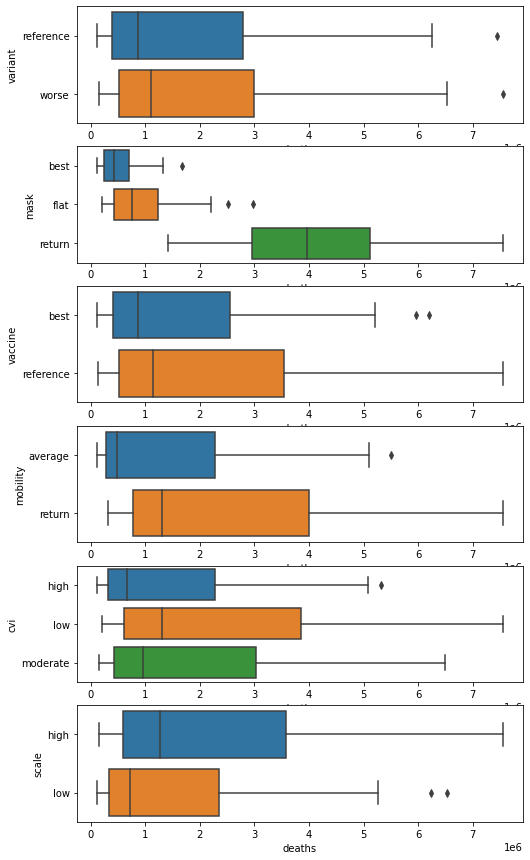

In [106]:
cols = [c for c in globe if c != 'deaths']
fig, ax = plt.subplots(nrows=len(cols), figsize=(8, 15))
for i, col in enumerate(cols):
    sns.boxplot(x='deaths', y=col, data=globe, ax=ax[i])

In [14]:
df.to_frame().to_parquet('/ihme/homes/collijk/working_set.parquet', engine='fastparquet', compression='gzip')

In [17]:
df.sort_index().loc[pd.IndexSlice[:, pd.Timestamp('8-1-2021'):pd.Timestamp('8-31-2022'), :, :, :, :, :, :]]

KeyboardInterrupt: 